In [1]:
!pwd

/eos/home-i00/t/tmazuret/SWAN_projects/NMF_dials/notebooks


## Importing libraries

In [2]:
# Setting up DIALS object and importing dqmexplore
import sys
sys.path.append("../DQMExplore/src/")

from utils.setupdials import setup_dials_object_deviceauth
dials = setup_dials_object_deviceauth()

[2024-11-19 12:30:10,368] INFO: Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-11-19 12:30:10,370] INFO: NumExpr defaulting to 8 threads.
[2024-11-19 12:30:12,589] INFO: This device will expire in 600 seconds.
[2024-11-19 12:30:12,591] INFO: Go to the following url and authenticate: https://auth.cern.ch/auth/realms/cern/device?user_code=BXPY-XXHA
[2024-11-19 12:30:12,592] INFO: Checking authorization status every 5 seconds...
[2024-11-19 12:30:18,217] INFO: Device authorized, authentication finished successfully!


In [3]:
# Importing DIALS objects
# For more information on DIALS, please visit https://github.com/cms-DQM/dials-py
from cmsdials.filters import LumisectionHistogram1DFilters, LumisectionHistogram2DFilters
from cmsdials.filters import OMSFilter, OMSPage

# All of the needed modules from DQMEplore (will be modified refactoring)
from dqmexplore.dataproc import trig_normalize
from dqmexplore.omsutils import get_rate
from dqmexplore.dataproc import generate_me_dict

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from matplotlib.lines import Line2D
from math import ceil

sys.path.append("../src/")
from datareco.data_reconstruction import DataReconstruction
from datareco.metrics import plot_euclidean_errors, calculate_outlier_dataframe, get_outliers_above_mse_limit, calculate_and_plot_mse, combine_outlier_dataframes
from filtering_before_training.filtering import normalize_by_area, contains_only_zeros_nan_or_inf, filter_and_normalize

## Loading MEs information from the DIALS

In [4]:
mes_list = dials.mes.list(LumisectionHistogram1DFilters())
df_me = pd.DataFrame(mes_list)
tracking_mes = df_me[df_me.iloc[:, 1].apply(lambda x: 'Tracking' in x[1])]

pd.set_option('display.max_colwidth', None)
tracking_mes.head(1)

,0,1,2,3
118,"(me_id, 10973340)","(me, Tracking/TrackParameters/generalTracks/GeneralProperties/Quality_GenTk)","(count, 704256)","(dim, 1)"


In [5]:
runnb = 383948
runnb_test = 384318
runnb_2 = 379765
runnb_test_2 = 380238
data1D = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb,
        dataset__regex = "ZeroBias",
        me = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
    ),
    max_pages=200
).to_pandas()

data1D_test = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb_test,
        dataset__regex = "ZeroBias",
        me = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
    ),
    max_pages=200
).to_pandas()

data1D_2 = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb_2,
        dataset__regex = "ZeroBias",
        me = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
    ),
    max_pages=200
).to_pandas()

data1D_test_2 = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb_test_2,
        dataset__regex = "ZeroBias",
        me = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
    ),
    max_pages=200
).to_pandas()

In [6]:
# Dictionaries out of the test and train data

# data1D_dict = generate_me_dict(data1D)
# data1D_dict_test = generate_me_dict(data1D_test)

# Keeping only 'data' after normalizing in the DataFrame

# trig_rate = get_rate(dials, runnb, "ZeroBias")
# # rtrn_np=True
# trig_rate_test = get_rate(dials, runnb_test, "ZeroBias")
# data1D_norm = trig_normalize(data1D_dict, trig_rate[:-2])
# data1D_norm_test = trig_normalize(data1D_dict_test, trig_rate_test)

In [7]:
file_path = '../fake_data.json'
data_fake = pd.read_json(file_path)

df_transposed_fake = data_fake.transpose()

data_list = []
ls_numbers = []

for index, row in df_transposed_fake.iterrows():
    ls_number = int(index[2:])  

    bin_values = row.tolist()

    data_list.append(bin_values)
    ls_numbers.append(ls_number)

fake_data_df = pd.DataFrame({
    'LS': ls_numbers,
    'data': data_list
})


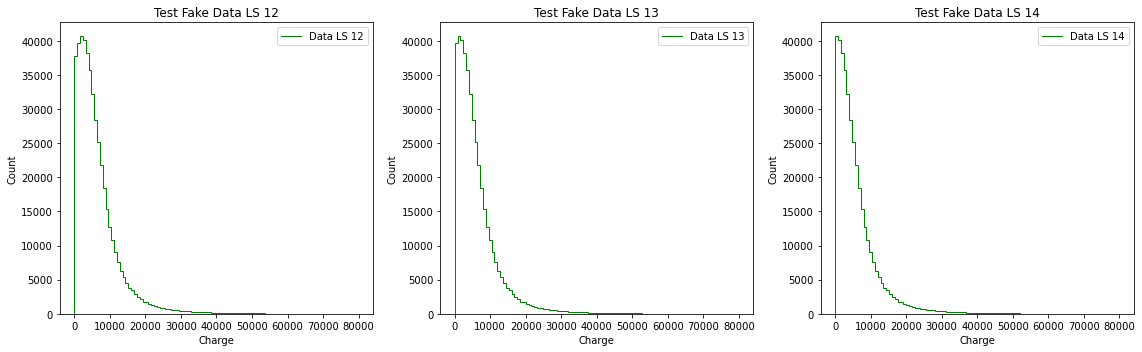

In [8]:
data_f = fake_data_df['data'].iloc[11:14]

x_min = 0
x_max = 80000
x_bin = 100
bin_edges = np.linspace(x_min, x_max, x_bin + 1)

ls_number = fake_data_df['LS'].iloc[11:14]

fig, axes = plt.subplots(1, 3, figsize=(16, 5)) 

for i in range(3):
    axes[i].stairs(data_f.iloc[i], bin_edges, color='g', label=f'Data LS {ls_number.iloc[i]}')
    axes[i].set_title(f'Test Fake Data LS {ls_number.iloc[i]}')
    axes[i].set_xlabel('Charge')
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()


# Data preparation

Normalization by the area under curve or trigger rate

In [9]:
df_filtered = data1D.copy()
df_filtered['data_normalized'] = df_filtered['data'].apply(filter_and_normalize)
df_filtered = df_filtered.dropna(subset=['data_normalized'])[['data_normalized']]  

df_filtered_test = data1D_test.copy()
df_filtered_test['data_normalized'] = df_filtered_test['data'].apply(filter_and_normalize)
# df_filtered_test['data_normalized'] = df_filtered_test.apply(lambda x: filter_and_normalize(x["data"]), axis=1)
df_filtered_test = df_filtered_test.dropna(subset=['data_normalized'])[['data_normalized']] 

df_filtered_2 = data1D_2.copy()
df_filtered_2['data_normalized'] = df_filtered_2['data'].apply(filter_and_normalize)
df_filtered_2 = df_filtered_2.dropna(subset=['data_normalized'])[['data_normalized']] 

df_filtered_test_2 = data1D_test_2.copy()
df_filtered_test_2['data_normalized'] = df_filtered_test_2['data'].apply(filter_and_normalize)
df_filtered_test_2 = df_filtered_test_2.dropna(subset=['data_normalized'])[['data_normalized']] 

df_filtered_fake = fake_data_df.copy()
df_filtered_fake['data_normalized'] = df_filtered_fake['data'].apply(filter_and_normalize)
df_filtered_fake = df_filtered_fake.dropna(subset=['data_normalized'])[['data_normalized']] 

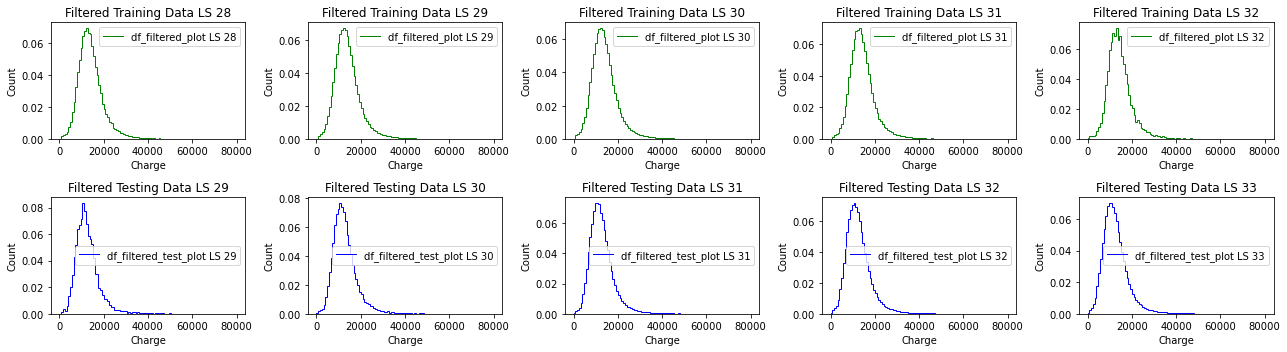

In [10]:
df_filtered_plot = df_filtered['data_normalized'].iloc[:5]
df_filtered_test_plot = df_filtered_test['data_normalized'].iloc[:5]

ls_number = df_filtered_plot.index 
ls_number_test = df_filtered_test_plot.index 

fig, axes = plt.subplots(2, 5, figsize=(18, 5))

# Training Data
for i in range(5):
    axes[0, i].stairs(df_filtered_plot.iloc[i], bin_edges, color='g', label=f'df_filtered_plot LS {ls_number[i]+1}')
    
    axes[0, i].set_title(f'Filtered Training Data LS {ls_number[i]+1}')
    axes[0, i].set_xlabel('Charge')
    axes[0, i].set_ylabel('Count')
    axes[0, i].legend()

# Test Data
for i in range(5):
    axes[1, i].stairs(df_filtered_test_plot.iloc[i], bin_edges, color='b', label=f'df_filtered_test_plot LS {ls_number_test[i]+1}')
    
    axes[1, i].set_title(f'Filtered Testing Data LS {ls_number_test[i]+1}')
    axes[1, i].set_xlabel('Charge')
    axes[1, i].set_ylabel('Count')
    axes[1, i].legend()
    
plt.tight_layout()
plt.show()

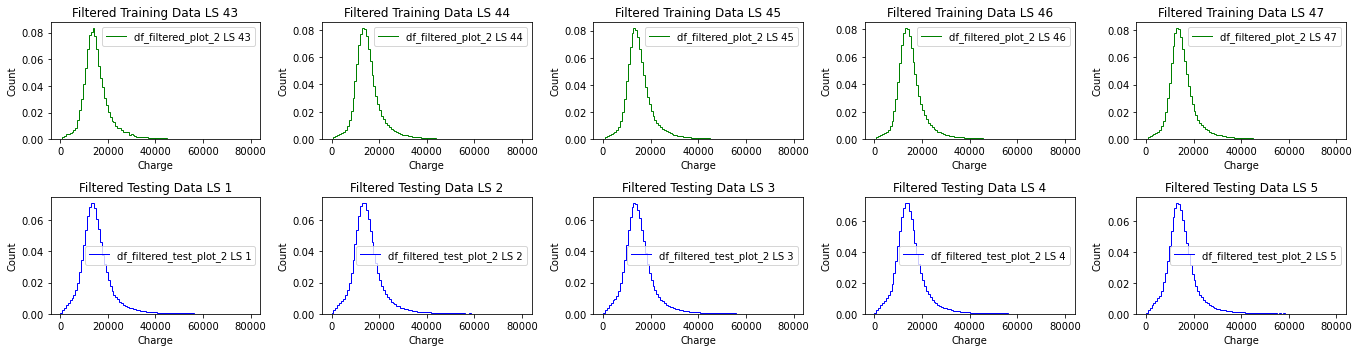

In [11]:
df_filtered_plot_2 = df_filtered_2['data_normalized'].iloc[:5]
df_filtered_test_plot_2 = df_filtered_test_2['data_normalized'].iloc[:5]

ls_number_2 = df_filtered_plot_2.index 
ls_number_test_2 = df_filtered_test_plot_2.index 

fig, axes = plt.subplots(2, 5, figsize=(19, 5))

# Training Data
for i in range(5):
    axes[0, i].stairs(df_filtered_plot_2.iloc[i], bin_edges, color='g', label=f'df_filtered_plot_2 LS {ls_number_2[i]+1}')
    
    axes[0, i].set_title(f'Filtered Training Data LS {ls_number_2[i]+1}')
    axes[0, i].set_xlabel('Charge')
    axes[0, i].set_ylabel('Count')
    axes[0, i].legend()

# Test Data
for i in range(5):
    axes[1, i].stairs(df_filtered_test_plot_2.iloc[i], bin_edges, color='b', label=f'df_filtered_test_plot_2 LS {ls_number_test_2[i]+1}')
    
    axes[1, i].set_title(f'Filtered Testing Data LS {ls_number_test_2[i]+1}')
    axes[1, i].set_xlabel('Charge')
    axes[1, i].set_ylabel('Count')
    axes[1, i].legend()
    
plt.tight_layout()
plt.show()

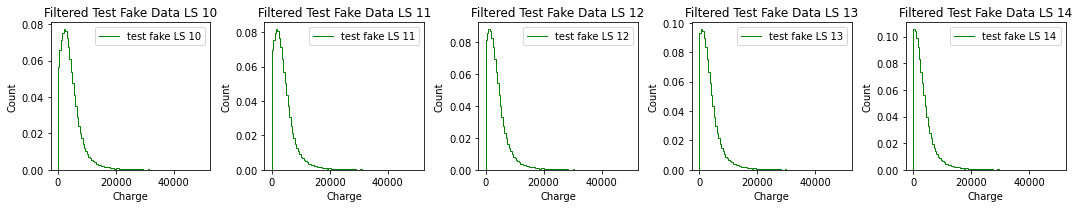

In [12]:
df_filtered_fake_plot = df_filtered_fake['data_normalized'].iloc[9:14]

ls_num = df_filtered_fake_plot.index 

x_min = 0
x_max = 50000
x_bin = 100
bin_edges = np.linspace(x_min, x_max, x_bin + 1)

fig, axes = plt.subplots(1, 5, figsize=(15, 3)) 

# Test Fake Data
for i in range(5):
    axes[i].stairs(df_filtered_fake_plot.iloc[i], bin_edges, color='g', label=f'test fake LS {ls_num[i]+1}')
    
    axes[i].set_title(f'Filtered Test Fake Data LS {ls_num[i]+1}')
    axes[i].set_xlabel('Charge')
    axes[i].set_ylabel('Count')
    axes[i].legend()
    
plt.tight_layout()
plt.show()

In [13]:
data_lists = df_filtered['data_normalized'].tolist()
data_lists_test = df_filtered_test['data_normalized'].tolist()

dense_matrix = np.array(data_lists)
dense_matrix_test = np.array(data_lists_test)

data_lists_2 = df_filtered_2['data_normalized'].tolist()
data_lists_test_2 = df_filtered_test_2['data_normalized'].tolist()

dense_matrix_2 = np.array(data_lists_2)
dense_matrix_test_2 = np.array(data_lists_test_2)

list_fake_test_matrix = df_filtered_fake['data_normalized'].tolist()
dense_matrix_fake_test = np.array(list_fake_test_matrix)

# Training the model

In [14]:
model = NMF(n_components= 4, random_state=1, init= "random", verbose = True)
W = model.fit_transform(dense_matrix)
H = model.components_

# Reconstructed trained data
reconstructed_matrix_train = np.dot(W, H)

# Transformation of the test data
#W_test = model.transform(dense_matrix_test)
W_test = model.transform(dense_matrix_fake_test)

# Reconstruction of the test data
reconstructed_matrix_test = np.dot(W_test, H)

print("\nW (Coefficient Matrix for Training Data):")
print(W)

print("\nH (Basis Matrix for Training Data):")
print(H)

print("\nReconstructed Training Matrix:")
print(reconstructed_matrix_train)

print("\nOriginal Test Matrix (Dense):")
#print(dense_matrix_test)
print(dense_matrix_fake_test)

print("\nW_test (Coefficient Matrix for Test Data):")
print(W_test)

print("\nReconstructed Test Matrix:")
print(reconstructed_matrix_test)

violation: 1.0
violation: 0.2824559889401453
violation: 0.02484665531930037
violation: 0.019170783133209145
violation: 0.017249755043226886
violation: 0.01609215716613432
violation: 0.014283819293118087
violation: 0.011608405981825238
violation: 0.008701410059572846
violation: 0.006364735657074925
violation: 0.004745953275397414
violation: 0.003693348594169514
violation: 0.0029952705902798037
violation: 0.002506937921607916
violation: 0.002148726795555429
violation: 0.0018730489230310776
violation: 0.0016392707277225191
violation: 0.0014607125798094883
violation: 0.0013106400829266313
violation: 0.0011855970290809436
violation: 0.0010788906816290409
violation: 0.000992198416844491
violation: 0.000919159218303512
violation: 0.0008575362702217898
violation: 0.0008033711554583715
violation: 0.000755512733803625
violation: 0.000713656039746982
violation: 0.0006767529121967135
violation: 0.0006443455737619415
violation: 0.00061632060857954
violation: 0.0005911401355606269
violation: 0.00056

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [15]:
model_2 = NMF(n_components=4, random_state=1, init="random", verbose=True)
W_2 = model_2.fit_transform(dense_matrix_2)
H_2 = model_2.components_

# Reconstructed trained data (Model 2)
reconstructed_matrix_train_2 = np.dot(W_2, H_2)

# Transformation of the test data (Model 2)
W_test_2 = model_2.transform(dense_matrix_test_2)

# Reconstruction of the test data (Model 2)
reconstructed_matrix_test_2 = np.dot(W_test_2, H_2)

# Output for Model 2
print("\nW (Coefficient Matrix for Training Data) - Model 2:")
print(W_2)

print("\nH (Basis Matrix for Training Data) - Model 2:")
print(H_2)

print("\nReconstructed Training Matrix - Model 2:")
print(reconstructed_matrix_train_2)

print("\nOriginal Test Matrix (Dense) - Model 2:")
print(dense_matrix_test_2)

print("\nW_test (Coefficient Matrix for Test Data) - Model 2:")
print(W_test_2)

print("\nReconstructed Test Matrix - Model 2:")
print(reconstructed_matrix_test_2)

violation: 1.0
violation: 0.41354341070647227
violation: 0.030873990815426373
violation: 0.02186995693401807
violation: 0.017186434817824763
violation: 0.014785575947568571
violation: 0.014026178577176869
violation: 0.014216849942002594
violation: 0.01380113061642904
violation: 0.01254224070765018
violation: 0.01070601667704876
violation: 0.00894449769157804
violation: 0.007572517007768967
violation: 0.006440525507079118
violation: 0.005619936969727942
violation: 0.00500682111109966
violation: 0.00453212207723829
violation: 0.004158615813826967
violation: 0.0038495380973724413
violation: 0.0035857989360573417
violation: 0.0033590780886053853
violation: 0.0031618621769612092
violation: 0.002995292496864346
violation: 0.0028579533981233727
violation: 0.0027511420826899823
violation: 0.0026631119800546396
violation: 0.0025827923465361487
violation: 0.0025044624374368613
violation: 0.00242257838455878
violation: 0.002339279319542095
violation: 0.0022530192424046044
violation: 0.00216561330

violation: 0.0001598767114722778
violation: 0.00013879952741823777
violation: 0.0001200524610348872
violation: 0.00010341295600376598
violation: 8.867644856093255e-05
Converged at iteration 68

W (Coefficient Matrix for Training Data) - Model 2:
[[0.07871074 0.09192904 0.         0.09086285]
 [0.07565248 0.08614555 0.00514071 0.09808856]
 [0.07790254 0.08435988 0.00329836 0.09605832]
 ...
 [0.00199427 0.0173327  0.11361942 0.23792281]
 [0.         0.         0.13887465 0.24658757]
 [0.         0.         0.17435921 0.20218014]]

H (Basis Matrix for Training Data) - Model 2:
[[1.53833720e-03 4.63644825e-03 1.77538685e-03 1.17180756e-03
  1.50384715e-03 7.35963934e-03 1.16250344e-02 2.38282285e-02
  4.93763150e-02 1.00199906e-01 1.63147830e-01 2.45075054e-01
  3.87961092e-01 5.13525390e-01 5.47768883e-01 6.50200593e-01
  5.75974241e-01 5.79272945e-01 5.48174167e-01 4.73631321e-01
  3.02638047e-01 2.58781138e-01 2.13142341e-01 2.06634113e-01
  1.35282432e-01 1.00722938e-01 9.34786056e-02 

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


# Reconstruction

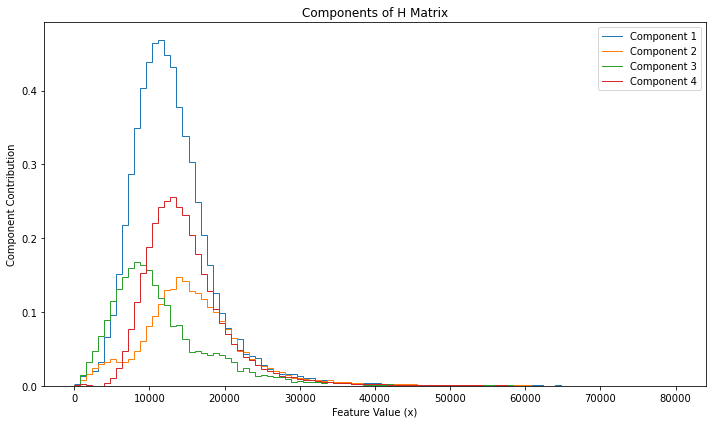

In [16]:
reconstruction_1 = DataReconstruction(W=W, H=H, dense_matrix=dense_matrix, W_test=W_test, dense_matrix_test=dense_matrix_fake_test, model_name="Model 1")
reconstruction_1.plot_all_components(variable_name='H')


--- Model 1 Component Contributions (Train) ---
Model 1 Component 1 (train) - Area Contribution: 64.00%, W Contribution: 41.13%, W Coefficient: 0.100863
Model 1 Component 2 (train) - Area Contribution: 20.60%, W Contribution: 35.11%, W Coefficient: 0.086100
Model 1 Component 3 (train) - Area Contribution: 11.21%, W Contribution: 18.71%, W Coefficient: 0.045889
Model 1 Component 4 (train) - Area Contribution: 4.18%, W Contribution: 5.04%, W Coefficient: 0.012363

--- Model 1 Component Contributions (Test) ---
Model 1 Component 1 (test) - Area Contribution: 0.00%, W Contribution: 0.00%, W Coefficient: 0.000000
Model 1 Component 2 (test) - Area Contribution: 0.00%, W Contribution: 0.00%, W Coefficient: 0.000000
Model 1 Component 3 (test) - Area Contribution: 100.00%, W Contribution: 100.00%, W Coefficient: 0.293083
Model 1 Component 4 (test) - Area Contribution: 0.00%, W Contribution: 0.00%, W Coefficient: 0.000000


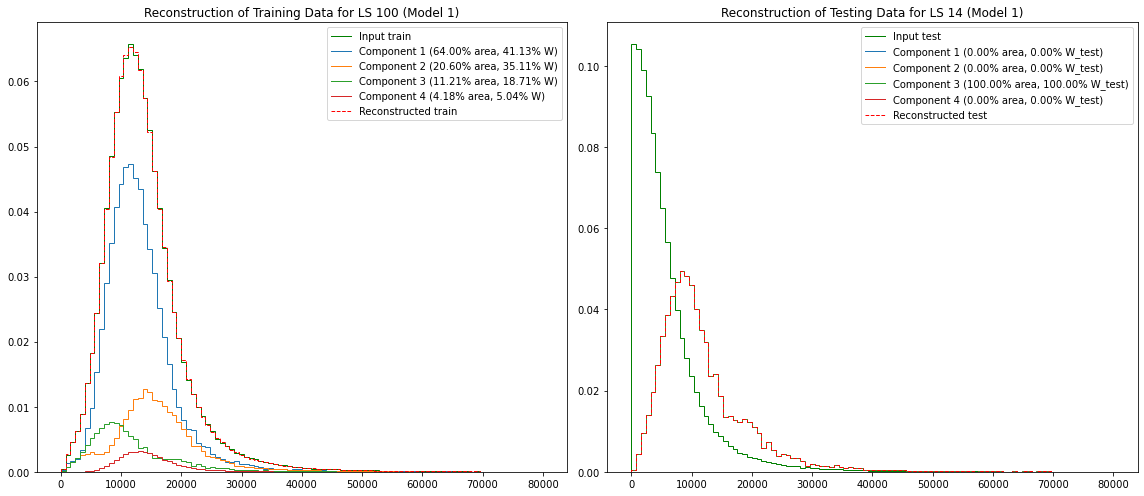

In [17]:
reconstruction_1.plot_reconstruction(ls_train=99, ls_test=13) # Always -1 to the real searched LS

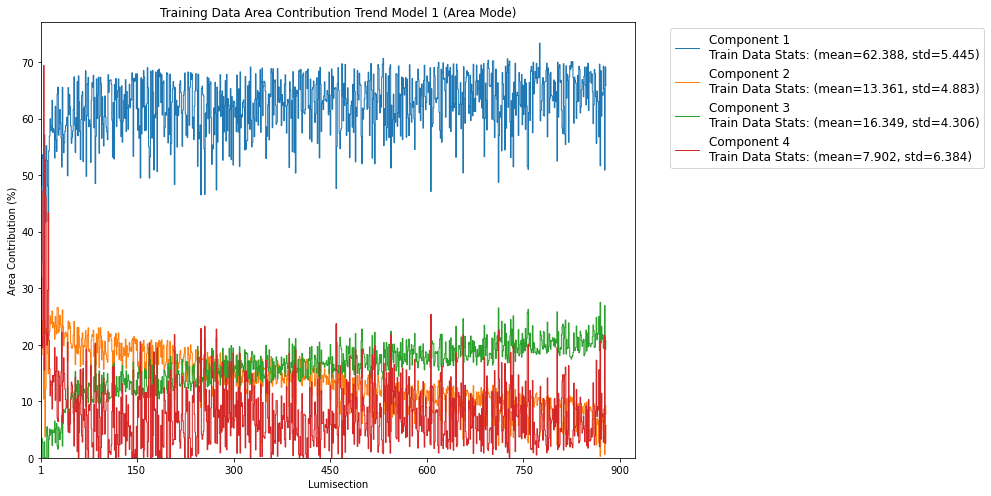

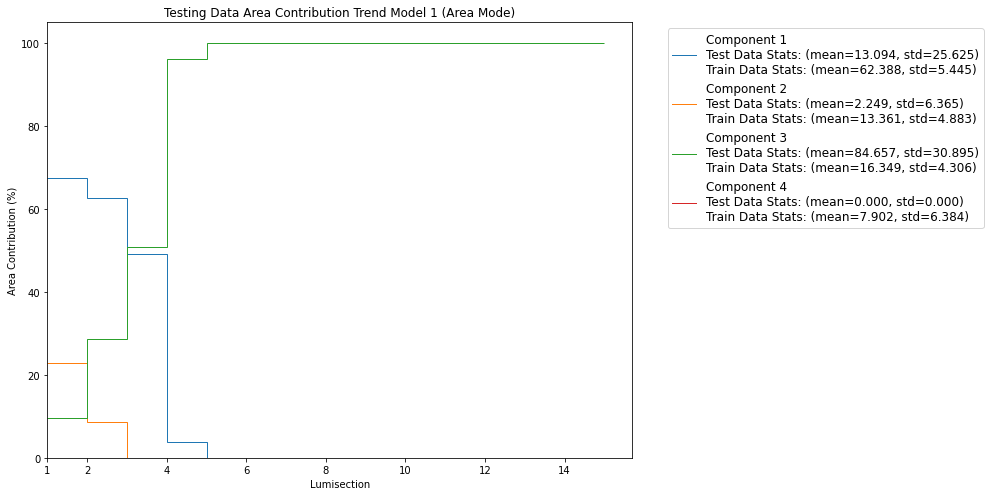

In [18]:
df_train_contributions_area = reconstruction_1.collect_contributions(
    W=reconstruction_1.W, 
    H=reconstruction_1.H, 
    dense_matrix=reconstruction_1.dense_matrix, 
    num_ls="all", 
    mode="area"
)

df_test_contributions_area = reconstruction_1.collect_contributions(
    W=reconstruction_1.W_test, 
    H=reconstruction_1.H, 
    dense_matrix=reconstruction_1.dense_matrix_test, 
    num_ls="all", 
    mode="area"
)

reconstruction_1.plot_trend(df=df_train_contributions_area, title="Training Data Area Contribution Trend Model 1", components="all", mode="area") #or "coef")

reconstruction_1.plot_trend(
    df=df_test_contributions_area, 
    title="Testing Data Area Contribution Trend Model 1", 
    components="all", 
    mode="area", 
    stats_from=df_train_contributions_area
)

In [19]:
plot_trend_train_outliers=reconstruction_1.detect_outliers(df=df_train_contributions_area)['LS']

In [20]:
plot_trend_test_outliers=reconstruction_1.detect_outliers(df=df_test_contributions_area, stats_from=df_train_contributions_area)

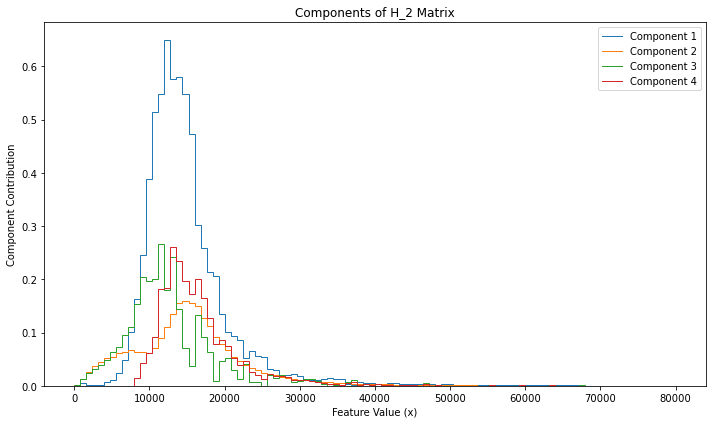

In [21]:
reconstruction_2 = DataReconstruction(W=W_2, H=H_2, dense_matrix=dense_matrix_2, W_test=W_test_2, dense_matrix_test=dense_matrix_test_2, model_name="Model 2")
reconstruction_2.plot_all_components(variable_name='H_2')


--- Model 2 Component Contributions (Train) ---
Model 2 Component 1 (train) - Area Contribution: 53.19%, W Contribution: 29.78%, W Coefficient: 0.077903
Model 2 Component 2 (train) - Area Contribution: 21.40%, W Contribution: 32.25%, W Coefficient: 0.084360
Model 2 Component 3 (train) - Area Contribution: 0.94%, W Contribution: 1.26%, W Coefficient: 0.003298
Model 2 Component 4 (train) - Area Contribution: 24.47%, W Contribution: 36.72%, W Coefficient: 0.096058

--- Model 2 Component Contributions (Test) ---
Model 2 Component 1 (test) - Area Contribution: 44.88%, W Contribution: 23.57%, W Coefficient: 0.065500
Model 2 Component 2 (test) - Area Contribution: 38.26%, W Contribution: 54.07%, W Coefficient: 0.150273
Model 2 Component 3 (test) - Area Contribution: 9.03%, W Contribution: 11.33%, W Coefficient: 0.031481
Model 2 Component 4 (test) - Area Contribution: 7.84%, W Contribution: 11.03%, W Coefficient: 0.030663


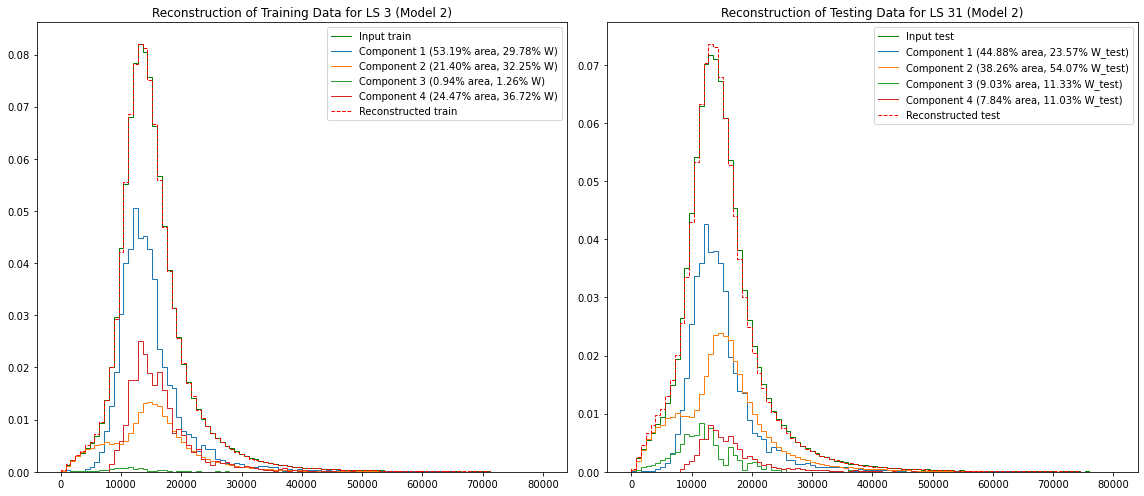

In [22]:
reconstruction_2.plot_reconstruction(ls_train=2, ls_test=30)

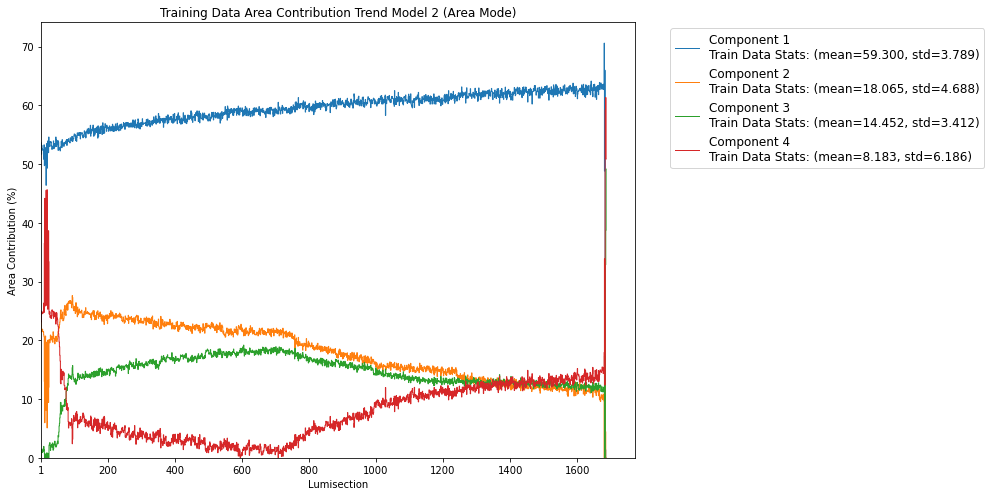

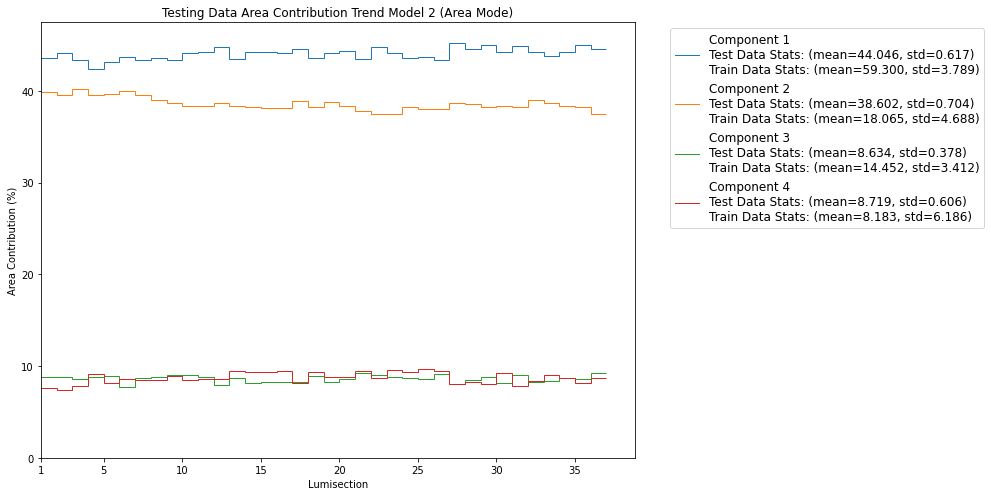

In [23]:
df_train_contributions_area_2 = reconstruction_2.collect_contributions(
    W=reconstruction_2.W, 
    H=reconstruction_2.H, 
    dense_matrix=reconstruction_2.dense_matrix, 
    num_ls="all", 
    mode="area"
)

df_test_contributions_area_2 = reconstruction_2.collect_contributions(
    W=reconstruction_2.W_test, 
    H=reconstruction_2.H, 
    dense_matrix=reconstruction_2.dense_matrix_test, 
    num_ls="all", 
    mode="area"
)

reconstruction_2.plot_trend(df=df_train_contributions_area_2, title="Training Data Area Contribution Trend Model 2", components="all", mode="area")

reconstruction_2.plot_trend(df=df_test_contributions_area_2, title="Testing Data Area Contribution Trend Model 2", components="all", mode="area", stats_from=df_train_contributions_area_2)

In [24]:
plot_trend_train_outliers_2=reconstruction_2.detect_outliers(df=df_train_contributions_area_2)

In [25]:
plot_trend_test_outliers_2=reconstruction_2.detect_outliers(df=df_test_contributions_area_2, stats_from=df_train_contributions_area_2)

# Metric

### Euclidean Distance

$$
\text{Euclidean Distance}_i = \sqrt{\sum_{j=1}^7 \left( \mathbf{w}_{\text{test}}^{i}[j] - \text{center}[j] \right)^2}
$$


In [26]:
outlier_euclid_error_train = calculate_outlier_dataframe(W)
outlier_euclid_error_test = calculate_outlier_dataframe(W, W_test)

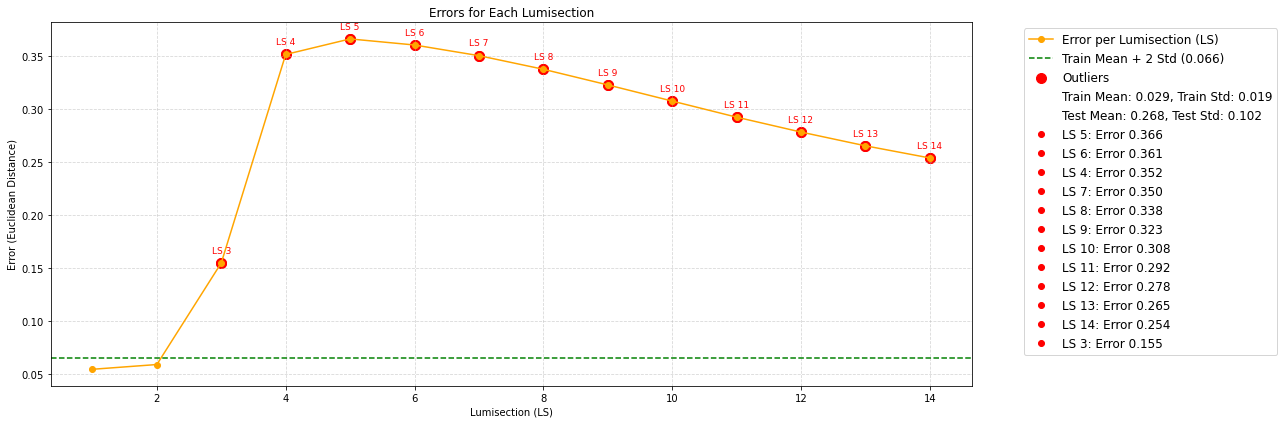

In [27]:
plot_euclidean_errors(W, W_test, top_n=12)

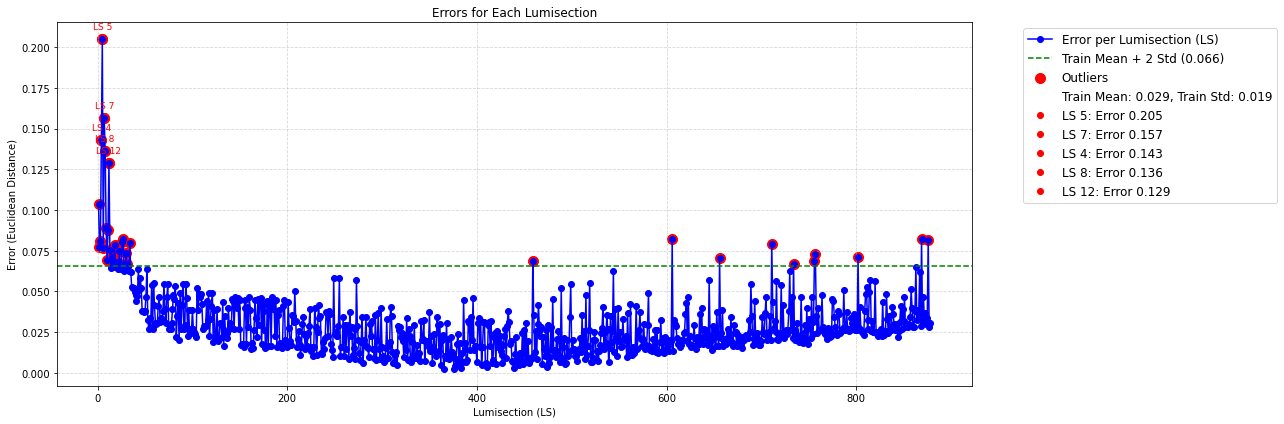

In [28]:
plot_euclidean_errors(W, top_n=5)

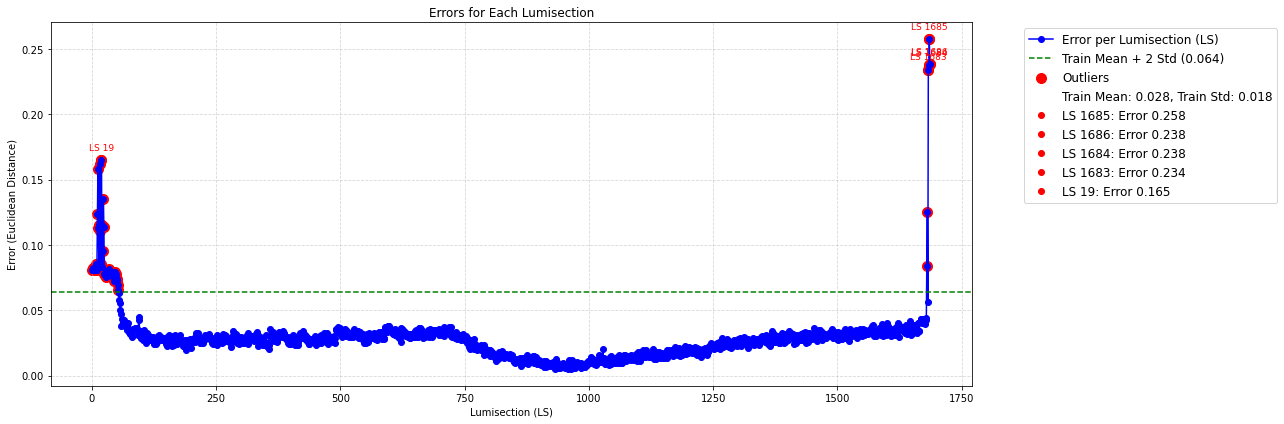

In [29]:
plot_euclidean_errors(W_2, top_n=5)

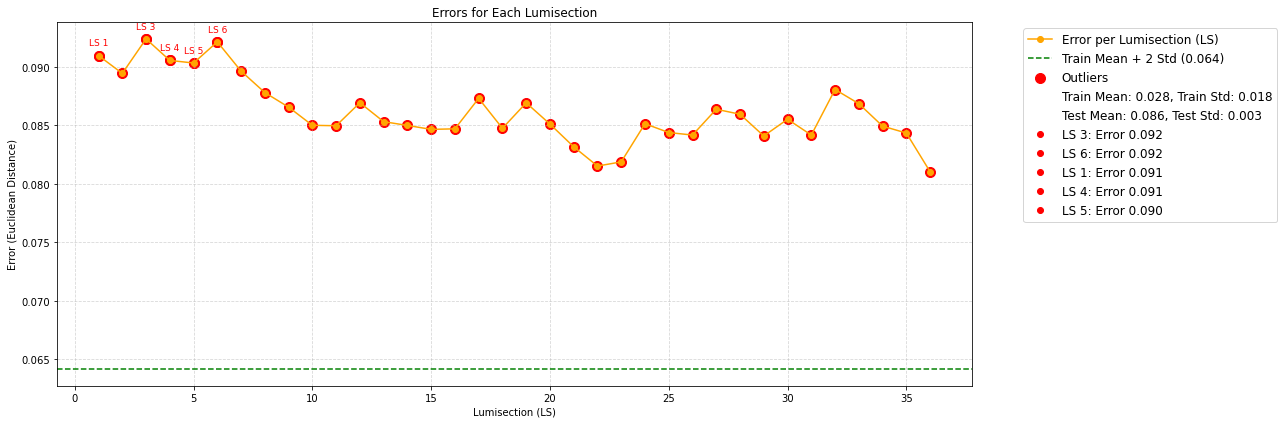

In [30]:
plot_euclidean_errors(W_2, W_test_2, top_n=5)

In [31]:
outlier_euclid_error_train_2 = calculate_outlier_dataframe(W_2)
outlier_euclid_error_test_2 = calculate_outlier_dataframe(W_2, W_test_2)

### Mean Squared Error (MSE)

$$
\text{MSE}_{\text{LS}_j} = \frac{1}{n_j} \sum_{i=1}^{n_j} \left( x_{j,i} - \hat{x}_{j,i} \right)^2
$$

- \( j \): The index for each lumisection (LS).
- \( n_j \): The number of data points in lumisection \( j \) (100 - bins).
- \( x_{j,i} \): The actual input data for the \( i \)-th data point in lumisection \( j \).
- \( \hat{x}_{j,i} \): The reconstructed data for the \( i \)-th data point in lumisection \( j \).


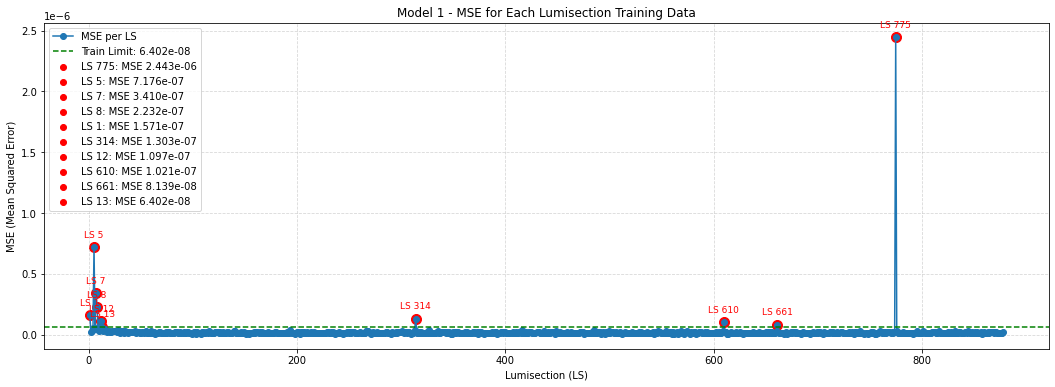

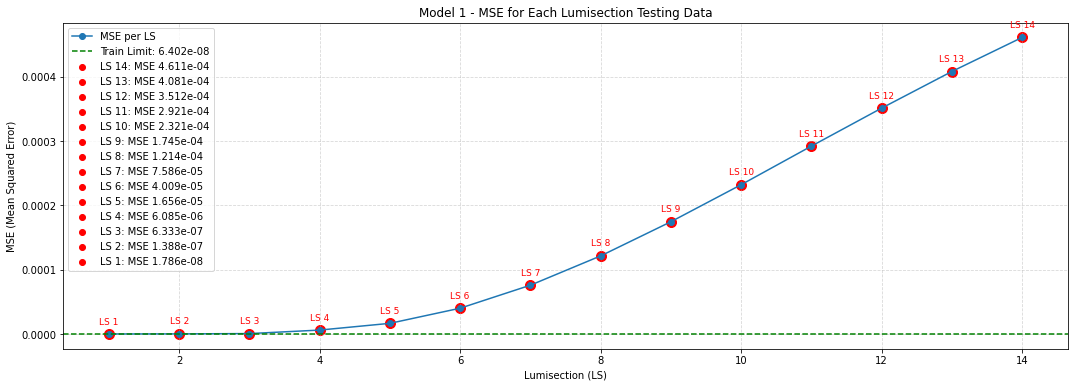

In [32]:
mse_errors_model_train_1 = calculate_and_plot_mse(
    matrix=dense_matrix,
    W=W,
    H=H,
    top_n=10,
    plot_title="Model 1 - MSE for Each Lumisection Training Data"
)
mse_errors_model_test_1 = calculate_and_plot_mse(
    matrix=dense_matrix_fake_test, #dense_matrix_test
    W=W,
    W_test=W_test,
    H=H,
    top_n=14,
    plot_title="Model 1 - MSE for Each Lumisection Testing Data"
)

In [33]:
mse_fake_test=get_outliers_above_mse_limit(matrix=dense_matrix_fake_test, W=W, W_test=W_test, H=H)

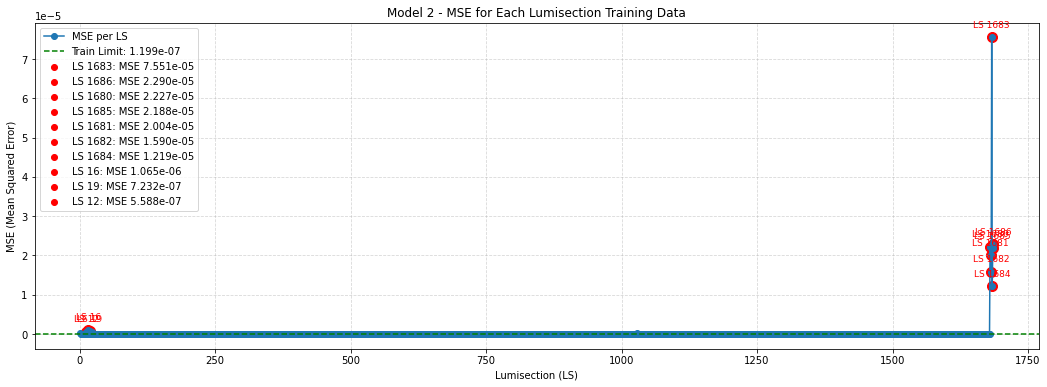

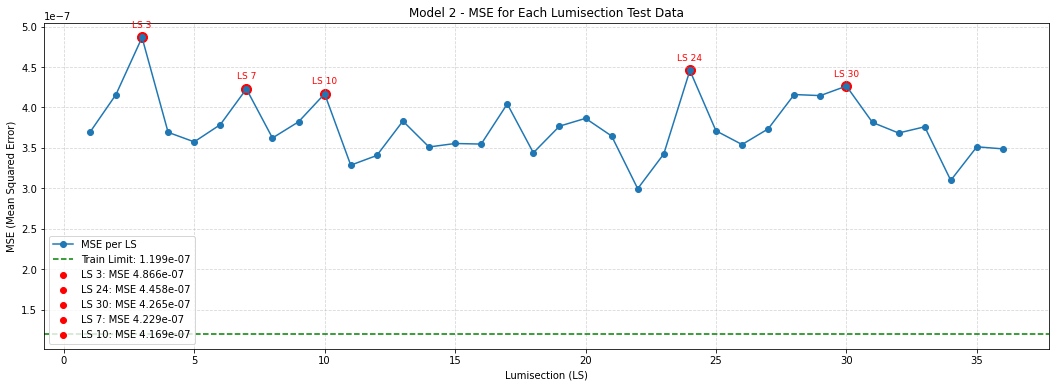

In [34]:
mse_errors_model_train_2 = calculate_and_plot_mse(matrix=dense_matrix_2, 
                                            W=W_2, 
                                            H=H_2, 
                                            top_n=10, 
                                            plot_title="Model 2 - MSE for Each Lumisection Training Data")
mse_errors_model_test_2 = calculate_and_plot_mse(matrix=dense_matrix_test_2, 
                                            W=W_2,
                                            W_test=W_test_2, 
                                            H=H_2, 
                                            top_n=5, 
                                            plot_title="Model 2 - MSE for Each Lumisection Test Data")

In [35]:
mse_test_2=get_outliers_above_mse_limit(matrix=dense_matrix_test_2, W=W_2, W_test=W_test_2, H=H_2)

In [36]:
combined_outliers_fake_df = combine_outlier_dataframes(
    plot_trend_df=plot_trend_test_outliers,
    euclid_error_df=outlier_euclid_error_test,
    mse_limit_df=mse_fake_test
)
combined_outliers_fake_df

,LS,Component_1,Component_2,Component_3,Component_4,Euclidean_dist,MSE
0,2,False,False,True,False,False,True
1,3,True,True,True,False,True,True
2,4,True,True,True,False,True,True
3,5,True,True,True,False,True,True
4,6,True,True,True,False,True,True
5,7,True,True,True,False,True,True
6,8,True,True,True,False,True,True
7,9,True,True,True,False,True,True
8,10,True,True,True,False,True,True
9,11,True,True,True,False,True,True


In [37]:
combined_outliers_test_df_2 = combine_outlier_dataframes(
    plot_trend_df=plot_trend_test_outliers_2,
    euclid_error_df=outlier_euclid_error_test_2,
    mse_limit_df=mse_test_2
)
combined_outliers_test_df_2

,LS,Component_1,Component_2,Component_3,Component_4,Euclidean_dist,MSE
0,1,True,True,False,False,True,True
1,2,True,True,False,False,True,True
2,3,True,True,False,False,True,True
3,4,True,True,False,False,True,True
4,5,True,True,False,False,True,True
5,6,True,True,False,False,True,True
6,7,True,True,False,False,True,True
7,8,True,True,False,False,True,True
8,9,True,True,False,False,True,True
9,10,True,True,False,False,True,True
